# Import

In [1]:
# import yfinance as yf
import pandas as pd
import os
from os.path import join
from datetime import datetime, timezone, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import logging
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from yforseer.networks import StockNet
from yforseer.datasets import StockDataset
from yforseer.trainers import StockNetTrainer
import mlflow
from tqdm import tqdm



# Dataset and loader

In [2]:

# Load dataset
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
data = torch.from_numpy(np.load(load_array_pth)['data']).to(torch.float32)
num_days = data.shape[1]
test_size = int(0.1 * num_days)
train_size = num_days - test_size
train_data = data[:, :train_size]
test_data = data[:, train_size:]
train_dataset = StockDataset(data = train_data, memory=60, lookahead=30, mode='last')
test_dataset = StockDataset(data = test_data, memory=60, lookahead=30, mode='last')
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))


train_dataset: 5283
test_dataset: 507


# Data Augmentation (Cauchy noise)

In [2]:
import pywt
from yforseer.augmentation import add_stockprice_noise, AddNoise

In [13]:
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
data = torch.from_numpy(np.load(load_array_pth)['data']).to(torch.float32)

# Augmentation function
stds = torch.diff(data, dim=1).std(dim=1).numpy()
# stds
# stds = np.ones(37) * 0.01

In [11]:
addnoise_transform = AddNoise(stds, 0.05, 1)
x = data
x1 = x[:, :60]
x2 = addnoise_transform(x1)



std = 0.03398
std = 0.02834
std = 0.02919
std = 0.02784
std = 0.01961
std = 0.03264


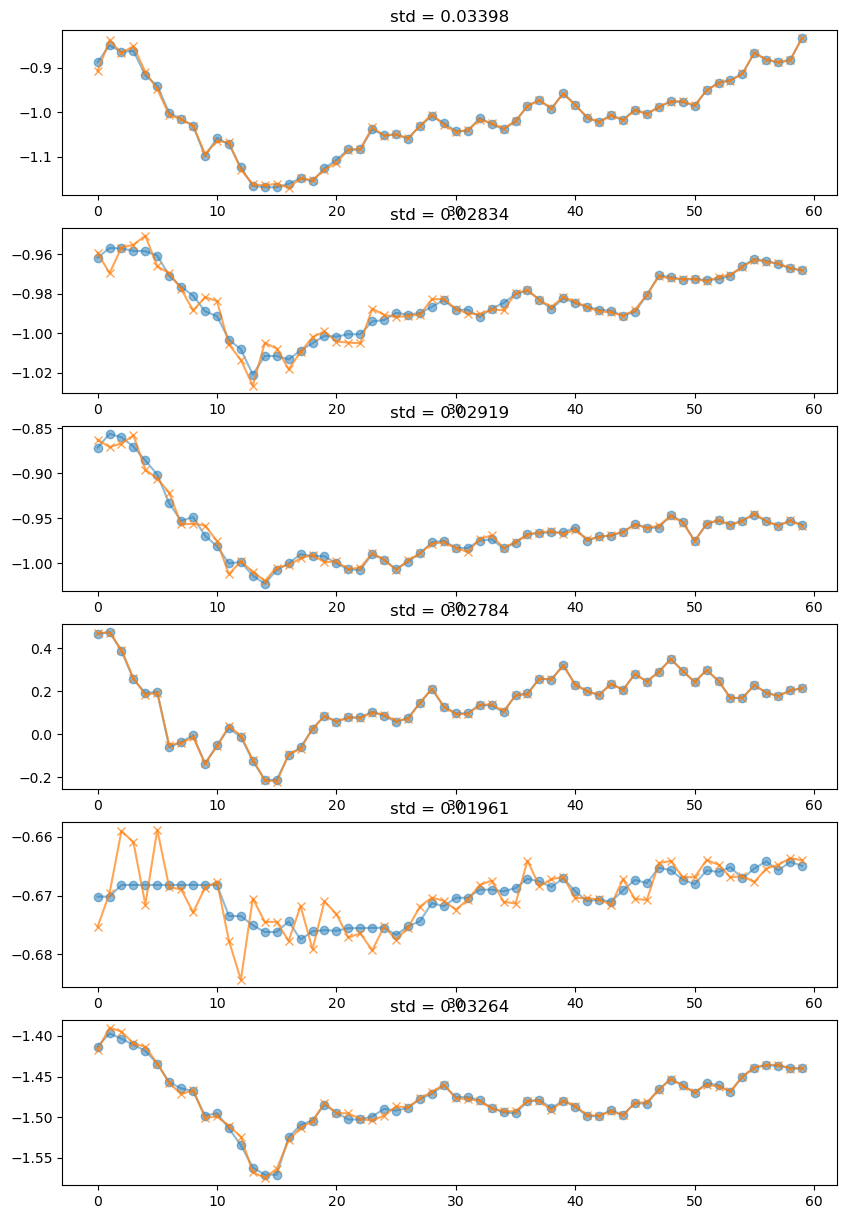

In [14]:
%matplotlib inline
i = 1
fig, ax = plt.subplots(6, 1, figsize=(10, 15))
for i in range(6):

    print(f'std = {stds[i]:0.5f}')
    
    ax[i].plot(x1[i, :], alpha=0.5, marker='o')
    ax[i].plot(x2[i, :], alpha=0.7, marker='x')
    ax[i].set_title(f'std = {stds[i]:0.5f}')


In [105]:
import mlflow
mlflow.end_run()

In [11]:
%matplotlib qt
import numpy as np
import pywt

# Assuming `signal` is your input time series signal
signal = x[0, :60]  # Example signal

ori_t = signal.shape[0]
# 1. Decompose the signal
coeffs = pywt.wavedec(signal, 'db4', level=None)  # Automatically determine decomposition level
cA = coeffs[0]  # Approximation coefficients (low-frequency)
cD = coeffs[1:]  # Detail coefficients (high-frequency)

# 2. High-frequency series is already isolated in cD

# 3. Add Gaussian noise to the high-frequency series
lam = 0.1
A = 1
scale = np.std(np.diff(signal)) * A
for i, cd in enumerate(cD):
    
    this_t = cd.shape[0]
    k = ori_t / this_t
    print(f'ori_t = {ori_t}, this_t = {this_t}, k = {k}')
    
    decay_power = np.arange(this_t) * k
    decay_factor = (1 - lam) **decay_power * scale
    print(decay_power)
    print(decay_factor)
    noise = np.random.normal(0, scale=decay_factor, size=this_t)  # Decreasing noise
    cD[i] = cd + noise

# 4. Combine the modified high-frequency series with the low-frequency series
modified_coeffs = [cA] + cD

# 5. Reconstruct the signal
reconstructed_signal = pywt.waverec(modified_coeffs, 'db4')

# Plotting the original and reconstructed signal for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(signal, label='Original Signal')
plt.plot(reconstructed_signal, label='Reconstructed Signal with Noise-Added High-Frequency', alpha=0.5)
plt.legend()
plt.show()

ori_t = 60, this_t = 13, k = 4.615384615384615
[ 0.          4.61538462  9.23076923 13.84615385 18.46153846 23.07692308
 27.69230769 32.30769231 36.92307692 41.53846154 46.15384615 50.76923077
 55.38461538]
[8.56670972e-03 5.26775579e-03 3.23919591e-03 1.99181408e-03
 1.22478647e-03 7.53133492e-04 4.63109344e-04 2.84770584e-04
 1.75108290e-04 1.07675845e-04 6.62109580e-05 4.07137826e-05
 2.50353136e-05]
ori_t = 60, this_t = 20, k = 3.0
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45. 48. 51.
 54. 57.]
[8.56670972e-03 6.24513139e-03 4.55270078e-03 3.31891887e-03
 2.41949186e-03 1.76380956e-03 1.28581717e-03 9.37360718e-04
 6.83335963e-04 4.98151917e-04 3.63152748e-04 2.64738353e-04
 1.92994259e-04 1.40692815e-04 1.02565062e-04 7.47699303e-05
 5.45072792e-05 3.97358066e-05 2.89674030e-05 2.11172368e-05]
ori_t = 60, this_t = 33, k = 1.8181818181818181
[ 0.          1.81818182  3.63636364  5.45454545  7.27272727  9.09090909
 10.90909091 12.72727273 14.54545455 16.36363636 1

In [97]:
cA_reconstructed = pywt.waverec([cA] + [None] * len(cD), 'db4')
plt.plot(signal, label='Original Signal')

plt.plot(cA_reconstructed, label='Approximation (cA) Reconstruction', alpha=0.7)


In [ ]:
# Reconstruct each level of detail coefficients into its time series representation
for i in range(len(cD)):
    # Create a list of None placeholders for all levels
    detail_coeffs = [None] * (len(cD) + 1)
    # Replace the placeholder of the current level with its detail coefficients
    detail_coeffs[i + 1] = cD[i]
    # Reconstruct the current level's time series
    cD_reconstructed.append(pywt.waverec(detail_coeffs, 'db4'))

In [66]:
wavelet = 'db4'
coeff = pywt.wavedec(x, wavelet, mode="per")

for i in range(len(coeff)):
    print(i, len(coeff[i]))

rec_coeff = [coeff[i] for i in range(len(coeff))]

# rec_coeff[-1] = rec_coeff[-1]/10

reconstructed_signal = pywt.waverec(rec_coeff, wavelet, mode="per" )


0 8
1 8
2 16
3 32
4 63
5 125
6 250
7 500


In [80]:
from copy import deepcopy


fig, ax = plt.subplots()
ax.plot(reconstructed_signal, label='All coeff')

for i in range(8):
    coeff_half = deepcopy(coeff)
    coeff_half[1][i:] = 0

    reconstructed_signal2 = pywt.waverec(coeff_half, wavelet, mode="per" )

    ax.plot(reconstructed_signal2, label='i=%d'%i)

ax.legend()


In [87]:
# pywt.upcoef('d', coeff[7], 'db4', level=1) + 
direct_recon = pywt.upcoef('a', coeff[0], 'db4', level=6)

plt.plot(reconstructed_signal)
plt.plot(direct_recon)


In [55]:
plt.plot(coeff[7])

In [57]:
%matplotlib qt
plt.plot(x)
plt.plot(reconstructed_signal)

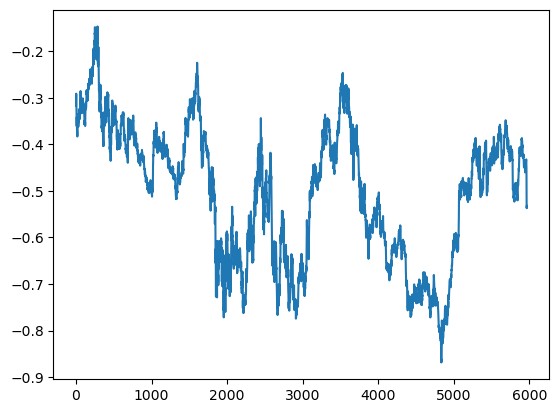

In [6]:
x = data[0, :]

plt.plot(x)

In [4]:
xdiff = np.diff(data, axis=1)
mds = np.median(xdiff, axis=1)
gammas = np.median(np.abs(xdiff - mds.reshape(-1, 1)), axis=1)
print(mds)
print(gammas)

[-1.34581207e-04 -3.73345853e-04 -1.87918788e-04 -6.57480518e-04
  7.47870637e-05  4.80577388e-05 -2.96552997e-04 -1.23780490e-04
 -4.78253810e-04 -2.17964666e-04 -3.73262899e-04 -2.63399862e-04
 -1.62304603e-04 -6.95632948e-05 -7.41880536e-05 -4.83317354e-05
 -1.70676309e-06 -1.65517486e-04 -4.94415664e-05  3.98083220e-06
 -1.16658931e-04 -1.07414616e-04 -9.09776322e-05  4.21008238e-05
 -7.77901132e-05 -1.34647649e-04 -2.29164183e-04 -4.35837442e-04
  9.85217158e-07 -3.44214456e-04 -8.16614127e-05 -2.70074302e-05
  1.67275089e-06 -1.03781213e-04 -1.08698463e-04  1.33341211e-06
 -4.16730064e-04]
[0.00456617 0.01406928 0.00936564 0.0135501  0.00558139 0.00475629
 0.00768252 0.01183807 0.00674872 0.00756358 0.0135226  0.01390011
 0.00651684 0.00445058 0.0037361  0.0037749  0.00553962 0.0081209
 0.00587823 0.00494116 0.01051899 0.00808454 0.00993664 0.00451333
 0.00405005 0.00456602 0.01164874 0.01710603 0.00505093 0.00645618
 0.00640125 0.01284077 0.00625733 0.00875654 0.0094962  0.00883

In [5]:

def truncated_cauchy(scale, N, bound):
    noise = np.ones(N) * bound *2
    mask = noise > bound
    while N > 0:
        noise[mask] = cauchy.rvs(loc=0, scale=scale, size=N)
        mask = np.abs(noise) > bound
        N = np.sum(mask)
    return noise




In [28]:
%matplotlib qt
i = 2
t = 1000

scale = gammas[i]
bound = 3* scale
foox = data[i, :t]

out_ids = np.where(np.abs(xdiff[i, :t]) > bound)[0]



fig, ax = plt.subplots( figsize=(10, 5))
ax.plot(foox, marker='x', color='b', alpha=0.3)
ax.scatter(out_ids, foox[out_ids], marker='o', color='red')


In [65]:
xax = np.linspace(-2, 2, 1000)
out = cauchy.pdf(xax, scale=gammas[i])
plt.plot(xax, out)

In [69]:
cauchy.ppf(0.9999, scale=gammas[i])

29.811767309109776

In [11]:
xdiff = np.diff(data, axis=1)

mu_each = xdiff.mean(axis=1)
std_each = xdiff.std(axis=1)



fig, ax = plt.subplots(8, 5, figsize=(20, 28))
ax = ax.flatten()
for i in range(37):

    mu, std = mu_each[i], std_each[i]
    min_val = mu - 3 * std
    max_val = mu + 3 * std

    md = np.median(xdiff[i])
    gamma = np.median(np.abs(xdiff[i] - md))


    edges = np.linspace(min_val, max_val, 100)
    hist, _ = np.histogram(xdiff[i], bins=edges)
    xax = np.linspace(min_val, max_val, 100)
    std = std/2
    # gau = cauchy.pdf(xax, loc=md, scale=gamma)
    gau = np.exp(-0.5 * ((xax - mu) / std) ** 2) / (std * np.sqrt(2 * np.pi))
    gau = gau / gau.max() * hist.max()
    
    ax[i].plot(xax, gau, c='r', lw=1)

    _ = ax[i].bar(edges[:-1], hist, width = edges[1] - edges[0], color='b', alpha=0.5)


In [25]:
x_tensor = torch.from_numpy(data)

stds = torch.std(x_tensor, dim=1).reshape(1, -1, 1) / 2

tensor([[[0.1441],
         [1.0046],
         [0.4234],
         [0.4097],
         [0.6027],
         [0.3010],
         [0.5857],
         [0.3993],
         [0.2752],
         [2.5785],
         [1.0262],
         [0.4114],
         [0.7476],
         [0.2562],
         [0.2335],
         [0.2829],
         [0.2408],
         [0.4517],
         [0.2882],
         [0.1269],
         [0.5012],
         [0.5189],
         [0.5263],
         [0.3159],
         [0.2216],
         [0.1441],
         [0.4210],
         [0.7138],
         [0.4387],
         [0.2848],
         [0.1955],
         [0.6754],
         [0.6295],
         [0.2557],
         [0.3130],
         [1.7915],
         [0.9734]]], dtype=torch.float64)

In [21]:
stds = torch.tensor([0, 10], dtype=torch.float32).reshape(1, 2, 1)
torch.normal(mean=0, std=stds)

tensor([[[ 0.0000],
         [-7.3291]]])